In [1]:
import os
from pathlib import Path
import requests
import datetime
import json
import pandas as pd
import numpy as np
%matplotlib inline

from alpha_vantage.timeseries import TimeSeries


In [2]:
from numpy.random import seed
seed(23)
from tensorflow import random

random.set_seed(32)

In [3]:
ts = TimeSeries(key='alpha_vantage_api')

# Get json object with the daily price data and another with  the call's metadata


#SPDR S&P 500 ETF 
sp500_etf_data, sp500_etf_meta_data = ts.get_daily('SPY', outputsize='full')
sp500_etf_data['2020-06-30']

{'1. open': '303.9900',
 '2. high': '310.2000',
 '3. low': '303.8200',
 '4. close': '308.3600',
 '5. volume': '112828251'}

In [4]:
df = []
for x in sp500_etf_data:
        date = x
        close = sp500_etf_data[x]['4. close']
        open_price = sp500_etf_data[x]['1. open']
        high_price = sp500_etf_data[x]['2. high']
        low_price = sp500_etf_data[x]['3. low']
        volume = sp500_etf_data[x]['5. volume']
        df.append({
            "Date": date,
            "Close": close,
            "Open": open_price,
            "High": high_price,
            "Low": low_price,
            "Volume": volume
        })
tickers_df = pd.DataFrame(df)
tickers_df = tickers_df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]
#tickers_df.sort_values(by='Date', ascending = False, inplace=True)
tickers_df['Date']= pd.to_datetime(tickers_df['Date'])
tickers_df.set_index("Date", inplace=True)
tickers_df.head()

,Close,Open,High,Low,Volume
Date,,,,,
2020-07-02,312.1900,314.2379,315.7000,310.5962,63712587
2020-07-01,310.5700,309.5700,311.8500,309.0371,71910372
2020-06-30,308.3600,303.9900,310.2000,303.8200,112828251
2020-06-29,304.4600,301.4100,304.6100,298.9300,79411577
2020-06-26,300.0500,306.1600,306.3900,299.4200,127811745


In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

### 2. Creating the features (X) and target (y) data using the window_data() function

In [6]:
window_size = 60
feature_column = 0
target_column = 0

X, y = window_data(tickers_df, window_size, feature_column, target_column)
# print (f"X sample values:\n{X[:5]} \n")
# print (f"y sample values:\n{y[:5]}")

### 3. Splitting Data Into Training and Testing

In [7]:
# Splitting 80% of the data for training and the remainder for testing.
split = int(0.80 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

### 4. Scale Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### 5. Reshape Data

In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

### 6. Build and Train Model

In [10]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# a. Define the LSTM RNN model.
model = Sequential()

 # Initial model setup
number_units = 60
dropout_fraction = 0.4

 # Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

 # Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

 # Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

 # Output layer
model.add(Dense(1))

In [12]:
# b. Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [13]:
# c. Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            14880     
_________________________________________________________________
dropout (Dropout)            (None, 60, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=30, verbose=1)

Epoch 1/10
133/133 [==============================] - 6s 48ms/step - loss: 0.0262
Epoch 2/10
133/133 [==============================] - 6s 48ms/step - loss: 0.0110
Epoch 3/10
133/133 [==============================] - 6s 49ms/step - loss: 0.0104
Epoch 4/10
133/133 [==============================] - 6s 49ms/step - loss: 0.0095
Epoch 5/10
133/133 [==============================] - 6s 49ms/step - loss: 0.0072
Epoch 6/10
133/133 [==============================] - 7s 49ms/step - loss: 0.0075
Epoch 7/10
133/133 [==============================] - 7s 49ms/step - loss: 0.0080
Epoch 8/10
133/133 [==============================] - 7s 50ms/step - loss: 0.0082
Epoch 9/10
133/133 [==============================] - 7s 53ms/step - loss: 0.0090
Epoch 10/10
133/133 [==============================] - 7s 53ms/step - loss: 0.0127


### 7. Make Predictions

In [15]:
# a. Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [16]:
# b. Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
0,113.77,109.660690
1,113.20,109.780251
2,113.63,109.868744
3,113.83,109.927719
4,114.00,109.964058


### 8. Evaluate Model Performance

In [17]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.0012141955085098743

### 9. Plot

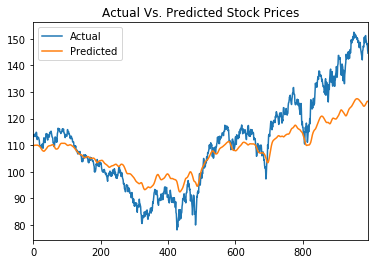

In [18]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted Stock Prices")